# 条件分岐を使った例


In [ ]:
import os
from typing import TypedDict, Literal
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END

load_dotenv()

llm = ChatOpenAI(model="gpt-5-nano")
output_parser = StrOutputParser()

# --- 状態の定義 ---
class State(TypedDict):
    query: str
    route: Literal["pricing", "general"]

# --- ノード関数 ---
def check_query(state: State) -> State:
    """LLMを使って質問の意図を判定し、適切なルートを選択する"""
    query = state["query"]

    # プロンプトテンプレートを作成
    prompt_template = ChatPromptTemplate.from_template("""
以下の質問を分析して、「pricing」または「general」のどちらのカテゴリに該当するか判定してください。

質問: {query}

判定基準:
- pricing: 料金、価格、値段、費用、コスト、お金に関する質問
- general: その他すべての質問（会社情報、サービス内容、使い方など）

回答は「pricing」または「general」のいずれかの単語のみで答えてください。
""")

    # チェーンを作成
    chain = prompt_template | llm | output_parser

    # チェーンを実行
    route = chain.invoke({"query": query}).strip().lower()
    state["route"] = route

    print(f"質問: {query}")
    print(f"判定結果: {state['route']}")
    return state

def pricing_info(state: State) -> State:
    print("料金情報: 料金は2,500円です。")
    return state

def general_info(state: State) -> State:
    print("一般情報: こちらが一般的な情報です。")
    return state

# --- グラフ構築 ---
graph = StateGraph(State)
graph.add_node("check", check_query)
graph.add_node("pricing", pricing_info)
graph.add_node("general", general_info)

graph.set_entry_point("check")
graph.add_conditional_edges(
    "check",
    lambda state: state["route"],  # 状態から次ノードを選ぶ
    {"pricing": "pricing", "general": "general"}
)

# 各ルートの終了点を設定
graph.add_edge("pricing", END)
graph.add_edge("general", END)

app = graph.compile()

# --- 実行例 ---
test_queries = [
    "料金について教えて",
    "会社について教えて",
    "いくらかかりますか？",
    "サービスの使い方を教えて"
]

for i, query in enumerate(test_queries, 1):
    print(f"\n=== 例{i}: {query} ===")
    app.invoke({"query": query})


=== 例1: 料金について教えて ===
質問: 料金について教えて
判定結果: pricing
料金情報: 料金は2,500円です。

=== 例2: 会社について教えて ===
質問: 会社について教えて
判定結果: general
一般情報: こちらが一般的な情報です。

=== 例3: いくらかかりますか？ ===
質問: いくらかかりますか？
判定結果: pricing
料金情報: 料金は2,500円です。

=== 例4: サービスの使い方を教えて ===
質問: サービスの使い方を教えて
判定結果: general
一般情報: こちらが一般的な情報です。


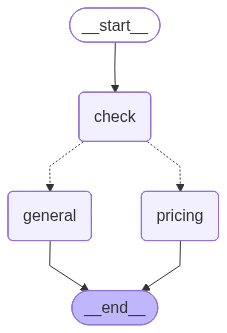

In [ ]:
from IPython.display import Image
# コンパイル済みグラフから図を生成して表示
Image(app.get_graph().draw_mermaid_png())